In [1]:
import mysql.connector as connection
import pandas as pd
import sys
sys.path.append('/Users/eavallon/Desktop/APA/shelterluv_cache/')
import sl_config
import matplotlib.pyplot as plt
import collections
import numpy as np
from scipy.stats import linregress
import statsmodels.api as sm

In [2]:
dbdw =connection.connect(host=sl_config.dbhost,user=sl_config.dbuser,passwd=sl_config.dbpassword,database=sl_config.database)

In [3]:
ret_query = """select e.EventSubtype                                                      AS ReturnType,
       if(et.IntakeReason is null,'Other', et.IntakeReason) AS ReturnReasonGroup,
       from_unixtime(e.EventTime)                                          AS EventDate,
              date_format(from_unixtime(e.EventTime),'%Y-%m') AS YearMonth,

       a.AnimalID                                                          AS AnimalID,
       a.AnimalName,
       a.AnimalBreed                                                       AS AnimalBreed,
       ifnull(breed.BreedSize, 'UNKNOWN')                                  AS BreedSize,
       FX_AGEDAYSTOAGEGROUP(to_days(from_unixtime(e.EventTime)) -
                              to_days(from_unixtime(a.AnimalDOBUnixTime))) AS IntakeAgeGroup,
       firstintakeevent.PartnerName                                        AS PartnerName,
       firstintakeevent.PartnerZipCode                                     AS PartnerZipCode,
       people.PersonID                                                     AS PersonID,
       people.PersonZip                                                    AS PersonZipCode,
       abs(to_days(firstintakeevent.FirstIntakeEventTime) - to_days(firstfosterevent.FirstFosterEventTime)) as DaysToFirstFosterEvent,
       if(abs(to_days(firstintakeevent.FirstIntakeEventTime) - to_days(firstfosterevent.FirstFosterEventTime)) <
          2, 1, 0)                                                             AS IsDirectToFosterIntake,
        if(euths.EuthType is null, 0,1) AS IsEuthanasiaOutcome,
        euths.EuthType AS EuthType,
        euths.EuthDate AS EuthDate,
       attr.IsDistemper                                                    AS IsDistemper,
       attr.EverDistemper                                                  AS EverDistemper,
       attr.IsMedicalConsult                                               AS IsMedicalConsult,
       attr.EverMedicalConsult                                             AS EverMedicalConsult,
       attr.IsBehaviorConsult                                              AS IsBehaviorConsult,
       attr.EverBehaviorConsult                                            AS EverBehaviorConsult,
       attr.IsHWPos                                                        AS IsHWPos,
       attr.EverHWPos                                                      AS EverHWPos,
       attr.IsRW                                                           AS IsRW,
       attr.EverRW                                                         AS EverRW,
       attr.IsNeonate                                                      AS IsNeonate,
       attr.EverNeonate                                                    AS EverNeonate,
       attr.IsNursing                                                      AS IsNursing,
       attr.EverNursing                                                    AS EverNursing,
       attr.IsParvo                                                        AS IsParvo,
       attr.EverParvo                                                      AS EverParvo,
       attr.IsPreadoptionTraining                                          AS IsPreadoptionTraining,
       attr.EverPreadoptionTraining                                        AS EverPreadoptionTraining,
       attr.IsBiteHistory                                                  AS IsBiteHistory,
       attr.IsResourceGuarder                                              AS IsResourceGuarder,
       attr.IsOnLeashReactive                                              AS IsOnLeashReactive,
       attr.IsDefensiveAggression                                          AS IsDefensiveAggression,
       attr.IsHandlerGuarding                                              AS IsHandlerGuarding,
       attr.IsTerritorialAggression                                        AS IsTerritorialAggression,
       attr.IsOverArousal                                                  AS IsOverArousal,
       attr.IsFlightRisk                                                   AS IsFlightRisk
from shelterluv.Events e
left join shelterluv.Animals a on e.`AnimalInternal-ID` = a.`AnimalInternal-ID`
left join shelterluv.People people on (e.`PartnerInternal-ID` = people.`PersonInternal-ID`)
left join datawarehouse.SL_AnimalsBreeds breed on (a.AnimalBreed = breed.AnimalBreed)
left join (select ah.`AnimalInternal-ID`,
                  if(ah.AttributeName in
                       ('Preadoption training required',
                        'Pre-adoption and post-adoption training required'), 1,0) as IsPreadoptTraining,
                  ah.DateStart,
                  ah.DateEnd
            from AnimalsAttributesHistory ah
            where AttributeName in
                       ('Preadoption training required',
                        'Pre-adoption and post-adoption training required')
            group by `AnimalInternal-ID`) preadopttraining on e.`AnimalInternal-ID` = preadopttraining.`AnimalInternal-ID`
left join (select ah.`AnimalInternal-ID` AS `AnimalInternal-ID`,
                max(if(ah.AttributeName =
                       'Distemper' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsDistemper,
                max(if(ah.AttributeName = 'Distemper', 1, 0))                          AS EverDistemper,
                max(if(ah.AttributeName like
                       'Medical Consult%' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsMedicalConsult,
                max(if(ah.AttributeName like 'Medical Consult%', 1, 0))                AS EverMedicalConsult,
                max(if(ah.AttributeName like
                       'Behavior Consult%' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsBehaviorConsult,
                max(if(ah.AttributeName like 'Behavior Consult%', 1, 0))               AS EverBehaviorConsult,
                max(if(ah.AttributeName =
                       'Heartworm +' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsHWPos,
                max(if(ah.AttributeName = 'Heartworm +', 1, 0))                        AS EverHWPos,
                max(if(ah.AttributeName in
                       ('Ringworm +', 'Ringworm') and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsRW,
                max(if(ah.AttributeName in
                       ('Ringworm +', 'Ringworm',
                        'Ringworm Graduate'), 1,
                       0))                                                                 AS EverRW,
                max(if(ah.AttributeName = 'Neonate' and ah.DateEnd is null, 1, 0)) AS IsNeonate,
                max(if(ah.AttributeName = 'Neonate', 1, 0))                            AS EverNeonate,
                max(if(ah.AttributeName =
                       'Nursing Mom' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsNursing,
                max(if(ah.AttributeName = 'Nursing Mom', 1, 0))                        AS EverNursing,
                max(if(ah.AttributeName = 'Parvo' and ah.DateEnd is null, 1, 0))   AS IsParvo,
                max(if(ah.AttributeName = 'Parvo', 1, 0))                              AS EverParvo,
                max(if(ah.AttributeName in
                       ('Preadoption training required',
                        'Pre-adoption and post-adoption training required') and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsPreadoptionTraining,
                max(if(ah.AttributeName in
                       ('Preadoption training required',
                        'Pre-adoption and post-adoption training required'),
                       1,
                       0))                                                                 AS EverPreadoptionTraining,
                max(if(ah.AttributeName like
                       'Bite History%' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsBiteHistory,
                max(if(ah.AttributeName like
                       'Resource Guarder%' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsResourceGuarder,
                max(if(ah.AttributeName like
                       'On Leash Reactivity%' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsOnLeashReactive,
                max(if(ah.AttributeName like
                       'Defensive Aggression%' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsDefensiveAggression,
                max(if(ah.AttributeName like
                       'Handler Guarding%' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsHandlerGuarding,
                max(if(ah.AttributeName like
                       'Territorial Aggression%' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsTerritorialAggression,
                max(if(ah.AttributeName like
                       'Over Arousal%' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsOverArousal,
                max(if(ah.AttributeName like
                       'Flight Risk%' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsFlightRisk
         from shelterluv.AnimalsAttributesHistory ah
         group by ah.`AnimalInternal-ID`) attr
         on (a.`AnimalInternal-ID` = attr.`AnimalInternal-ID`)
left join shelterluv.EventTypes et on (concat(e.EventType, '.', e.EventSubtype) = et.EventTypeSubType)
left join (select *
           from (select shelterluv.Events.EventType AS EventType,
                      from_unixtime(shelterluv.Events.EventTime) AS FirstIntakeEventTime,
                      partner.PartnerName AS PartnerName,
                      partner.ZipCode AS PartnerZipCode,
                      shelterluv.Events.`AnimalInternal-ID` AS `AnimalInternal-ID`,
                      row_number() over ( partition by shelterluv.Events.`AnimalInternal-ID`
                          order by shelterluv.Events.`AnimalInternal-ID`,shelterluv.Events.EventTime) AS RowNum
               from shelterluv.Events
               left join shelterluv.Partners partner on Events.`PartnerInternal-ID` = partner.`PartnerInternal-ID`
               where shelterluv.Events.EventType like 'Intake%') rn
         where rn.RowNum = 1) firstintakeevent on (e.`AnimalInternal-ID` = firstintakeevent.`AnimalInternal-ID`)
left join (select *
           from (select shelterluv.Events.EventType                                                                                                                                AS EventType,
                      from_unixtime(shelterluv.Events.EventTime)                                                                                                                 AS FirstFosterEventTime,
                      shelterluv.Events.`AnimalInternal-ID`  AS `AnimalInternal-ID`,
                      People.PersonZip AS PersonZip,
                      People.PersonID,
                      row_number() over ( partition by shelterluv.Events.`AnimalInternal-ID` order by shelterluv.Events.`AnimalInternal-ID`,shelterluv.Events.EventTime) AS RowNum
               from shelterluv.Events
               left join People on Events.`PersonInternal-ID` = People.`PersonInternal-ID`
               where shelterluv.Events.EventType = 'Outcome.Foster') rn
         where rn.RowNum = 1) firstfosterevent on (e.`AnimalInternal-ID` = firstfosterevent.`AnimalInternal-ID`)
left join(select EventType,
                 EventSubtype AS EuthType,
                 `AnimalInternal-ID`,
                 from_unixtime(EventTime) as EuthDate
          from Events
          where EventType = 'Outcome.Euthanasia') euths on e.`AnimalInternal-ID` = euths.`AnimalInternal-ID`
where e.EventType = 'Intake.AdoptionReturn'
and from_unixtime(e.EventTime) >= '2021-01-01 00:00:00.0'
  and a.AnimalType = 'Dog'"""

In [4]:
adopt_query = """select e.EventSubtype                                                      AS ReturnType,
       if(et.IntakeReason is null,'Other', et.IntakeReason) AS ReturnReasonGroup,
       from_unixtime(e.EventTime)                                          AS EventDate,
              date_format(from_unixtime(e.EventTime),'%Y-%m') AS YearMonth,
       a.AnimalID                                                          AS AnimalID,
       a.AnimalName,
       IF(a.AnimalBreed like '%Pit Bull%' or a.AnimalBreed like '%American Staffordshire%',
           'Bully Breed', a.AnimalBreed) as AnimalBreed,
       ifnull(breed.BreedSize, 'UNKNOWN')                                  AS BreedSize,
       FX_AGEDAYSTOAGEGROUP(to_days(from_unixtime(e.EventTime)) -
                              to_days(from_unixtime(a.AnimalDOBUnixTime))) AS IntakeAgeGroup,
       firstintakeevent.PartnerName                                        AS PartnerName,
       firstintakeevent.PartnerZipCode                                     AS PartnerZipCode,
       people.PersonID                                                     AS PersonID,
       people.PersonZip                                                    AS PersonZipCode,
       abs(to_days(firstintakeevent.FirstIntakeEventTime) - to_days(firstfosterevent.FirstFosterEventTime)) as DaysToFirstFosterEvent,
       if(abs(to_days(firstintakeevent.FirstIntakeEventTime) - to_days(firstfosterevent.FirstFosterEventTime)) <
          2, 1, 0)                                                             AS IsDirectToFosterIntake,
        if(euths.EuthType is null, 0,1) AS IsEuthanasiaOutcome,
        euths.EuthType AS EuthType,
        euths.EuthDate AS EuthDate,
       attr.IsDistemper                                                    AS IsDistemper,
       attr.EverDistemper                                                  AS EverDistemper,
       attr.IsMedicalConsult                                               AS IsMedicalConsult,
       attr.EverMedicalConsult                                             AS EverMedicalConsult,
       attr.IsBehaviorConsult                                              AS IsBehaviorConsult,
       attr.EverBehaviorConsult                                            AS EverBehaviorConsult,
       attr.IsHWPos                                                        AS IsHWPos,
       attr.EverHWPos                                                      AS EverHWPos,
       attr.IsRW                                                           AS IsRW,
       attr.EverRW                                                         AS EverRW,
       attr.IsNeonate                                                      AS IsNeonate,
       attr.EverNeonate                                                    AS EverNeonate,
       attr.IsNursing                                                      AS IsNursing,
       attr.EverNursing                                                    AS EverNursing,
       attr.IsParvo                                                        AS IsParvo,
       attr.EverParvo                                                      AS EverParvo,
       attr.IsPreadoptionTraining                                          AS IsPreadoptionTraining,
       attr.EverPreadoptionTraining                                        AS EverPreadoptionTraining,
       attr.IsBiteHistory                                                  AS IsBiteHistory,
       attr.IsResourceGuarder                                              AS IsResourceGuarder,
       attr.IsOnLeashReactive                                              AS IsOnLeashReactive,
       attr.IsDefensiveAggression                                          AS IsDefensiveAggression,
       attr.IsHandlerGuarding                                              AS IsHandlerGuarding,
       attr.IsTerritorialAggression                                        AS IsTerritorialAggression,
       attr.IsOverArousal                                                  AS IsOverArousal,
       attr.IsFlightRisk                                                   AS IsFlightRisk
from shelterluv.Events e
left join shelterluv.Animals a on e.`AnimalInternal-ID` = a.`AnimalInternal-ID`
left join shelterluv.People people on (e.`PartnerInternal-ID` = people.`PersonInternal-ID`)
left join datawarehouse.SL_AnimalsBreeds breed on (a.AnimalBreed = breed.AnimalBreed)
left join (select ah.`AnimalInternal-ID`,
                  if(ah.AttributeName in
                       ('Preadoption training required',
                        'Pre-adoption and post-adoption training required'), 1,0) as IsPreadoptTraining,
                  ah.DateStart,
                  ah.DateEnd
            from AnimalsAttributesHistory ah
            where AttributeName in
                       ('Preadoption training required',
                        'Pre-adoption and post-adoption training required')
            group by `AnimalInternal-ID`) preadopttraining on e.`AnimalInternal-ID` = preadopttraining.`AnimalInternal-ID`
left join (select ah.`AnimalInternal-ID` AS `AnimalInternal-ID`,
                max(if(ah.AttributeName =
                       'Distemper' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsDistemper,
                max(if(ah.AttributeName = 'Distemper', 1, 0))                          AS EverDistemper,
                max(if(ah.AttributeName like
                       'Medical Consult%' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsMedicalConsult,
                max(if(ah.AttributeName like 'Medical Consult%', 1, 0))                AS EverMedicalConsult,
                max(if(ah.AttributeName like
                       'Behavior Consult%' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsBehaviorConsult,
                max(if(ah.AttributeName like 'Behavior Consult%', 1, 0))               AS EverBehaviorConsult,
                max(if(ah.AttributeName =
                       'Heartworm +' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsHWPos,
                max(if(ah.AttributeName = 'Heartworm +', 1, 0))                        AS EverHWPos,
                max(if(ah.AttributeName in
                       ('Ringworm +', 'Ringworm') and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsRW,
                max(if(ah.AttributeName in
                       ('Ringworm +', 'Ringworm',
                        'Ringworm Graduate'), 1,
                       0))                                                                 AS EverRW,
                max(if(ah.AttributeName = 'Neonate' and ah.DateEnd is null, 1, 0)) AS IsNeonate,
                max(if(ah.AttributeName = 'Neonate', 1, 0))                            AS EverNeonate,
                max(if(ah.AttributeName =
                       'Nursing Mom' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsNursing,
                max(if(ah.AttributeName = 'Nursing Mom', 1, 0))                        AS EverNursing,
                max(if(ah.AttributeName = 'Parvo' and ah.DateEnd is null, 1, 0))   AS IsParvo,
                max(if(ah.AttributeName = 'Parvo', 1, 0))                              AS EverParvo,
                max(if(ah.AttributeName in
                       ('Preadoption training required',
                        'Pre-adoption and post-adoption training required') and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsPreadoptionTraining,
                max(if(ah.AttributeName in
                       ('Preadoption training required',
                        'Pre-adoption and post-adoption training required'),
                       1,
                       0))                                                                 AS EverPreadoptionTraining,
                max(if(ah.AttributeName like
                       'Bite History%' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsBiteHistory,
                max(if(ah.AttributeName like
                       'Resource Guarder%' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsResourceGuarder,
                max(if(ah.AttributeName like
                       'On Leash Reactivity%' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsOnLeashReactive,
                max(if(ah.AttributeName like
                       'Defensive Aggression%' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsDefensiveAggression,
                max(if(ah.AttributeName like
                       'Handler Guarding%' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsHandlerGuarding,
                max(if(ah.AttributeName like
                       'Territorial Aggression%' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsTerritorialAggression,
                max(if(ah.AttributeName like
                       'Over Arousal%' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsOverArousal,
                max(if(ah.AttributeName like
                       'Flight Risk%' and
                       ah.DateEnd is null, 1,
                       0))                                                                 AS IsFlightRisk
         from shelterluv.AnimalsAttributesHistory ah
         group by ah.`AnimalInternal-ID`) attr
         on (a.`AnimalInternal-ID` = attr.`AnimalInternal-ID`)
left join shelterluv.EventTypes et on (concat(e.EventType, '.', e.EventSubtype) = et.EventTypeSubType)
left join (select *
           from (select shelterluv.Events.EventType AS EventType,
                      from_unixtime(shelterluv.Events.EventTime) AS FirstIntakeEventTime,
                      partner.PartnerName AS PartnerName,
                      partner.ZipCode AS PartnerZipCode,
                      shelterluv.Events.`AnimalInternal-ID` AS `AnimalInternal-ID`,
                      row_number() over ( partition by shelterluv.Events.`AnimalInternal-ID`
                          order by shelterluv.Events.`AnimalInternal-ID`,shelterluv.Events.EventTime) AS RowNum
               from shelterluv.Events
               left join shelterluv.Partners partner on Events.`PartnerInternal-ID` = partner.`PartnerInternal-ID`
               where shelterluv.Events.EventType like 'Intake%') rn
         where rn.RowNum = 1) firstintakeevent on (e.`AnimalInternal-ID` = firstintakeevent.`AnimalInternal-ID`)
left join (select *
           from (select shelterluv.Events.EventType                                                                                                                                AS EventType,
                      from_unixtime(shelterluv.Events.EventTime)                                                                                                                 AS FirstFosterEventTime,
                      shelterluv.Events.`AnimalInternal-ID`  AS `AnimalInternal-ID`,
                      People.PersonZip AS PersonZip,
                      People.PersonID,
                      row_number() over ( partition by shelterluv.Events.`AnimalInternal-ID` order by shelterluv.Events.`AnimalInternal-ID`,shelterluv.Events.EventTime) AS RowNum
               from shelterluv.Events
               left join People on Events.`PersonInternal-ID` = People.`PersonInternal-ID`
               where shelterluv.Events.EventType = 'Outcome.Foster') rn
         where rn.RowNum = 1) firstfosterevent on (e.`AnimalInternal-ID` = firstfosterevent.`AnimalInternal-ID`)
left join(select EventType,
                 EventSubtype AS EuthType,
                 `AnimalInternal-ID`,
                 from_unixtime(EventTime) as EuthDate
          from Events
          where EventType = 'Outcome.Euthanasia') euths on e.`AnimalInternal-ID` = euths.`AnimalInternal-ID`
where e.EventType = 'Outcome.Adoption'
and from_unixtime(e.EventTime) >= '2021-01-01 00:00:00.0'
  and a.AnimalType = 'Dog'"""

In [5]:
ret = pd.read_sql(ret_query,dbdw)

In [6]:
adopt = pd.read_sql(adopt_query,dbdw)

In [7]:
ret_counter = collections.Counter(ret['YearMonth'])
ret_ct = pd.DataFrame.from_dict(ret_counter, orient='index').reset_index().rename(columns={'index':'YearMonth',0:'ReturnNumber'}).sort_values(by='YearMonth').reset_index().drop(columns='index')

In [8]:
adopt_counter = collections.Counter(adopt['YearMonth'])
adopt_ct = pd.DataFrame.from_dict(adopt_counter, orient='index').reset_index().rename(columns={'index':'YearMonth',0:'AdoptNumber'}).sort_values(by='YearMonth').reset_index().drop(columns='index')

In [9]:
ret_ct

,YearMonth,ReturnNumber
0,2021-01,9
1,2021-02,8
2,2021-03,14
3,2021-04,8
4,2021-05,9
5,2021-06,5
6,2021-07,10
7,2021-08,6
8,2021-09,16
9,2021-10,13


In [10]:
x = dict(sorted(collections.Counter(ret['ReturnType']).items(),key=lambda y:y[1]))
counts = np.array(list(x.values()))/len(ret)
pct = counts*100
rts = list(x.keys())

Text(0.23323741007194246, 13.9, 'Unrealistic Expectations: 45.3%')

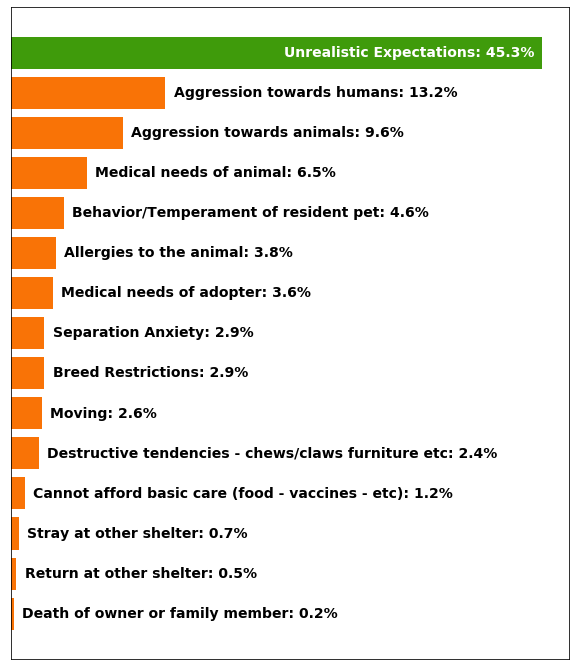

In [11]:
l = range(len(x.keys()))
plt.figure(figsize=(10,12))
plt.barh(l, counts, align='center',color='xkcd:orange')
plt.barh(l[-1],counts[-1],align='center',color='xkcd:grass green')
plt.xticks([])
plt.yticks([])
for i in range(len(l))[:-1]:
    plt.text(counts[i] + 0.007,l[i]-0.1,rts[i] + ': ' + str(round(pct[i],1)) + '%',
             wrap=True,fontweight='bold',fontsize=14)
plt.text(counts[-1]-0.22,l[-1]-0.1,rts[-1] + ': ' + str(round(pct[-1],1)) + '%',
         wrap=True,fontweight='bold',fontsize=14,c='xkcd:white')
# plt.title('Dog Adoption Return Reasons: 2021 - Present',fontweight='bold',fontsize=18)

In [12]:
ue = ret[ret['ReturnType'] == 'Unrealistic Expectations']

In [13]:
uebc = np.array(list(collections.Counter(ue['IsBehaviorConsult']).values()))
uemc = np.array(list(collections.Counter(ue['IsMedicalConsult']).values()))
uepat = np.array(list(collections.Counter(ue['IsPreadoptionTraining']).values()))

In [31]:
coef = np.polyfit(ret_ct['ReturnNumber']/adopt_ct['AdoptNumber'],range(len(ret_ct)), deg=1)
poly1d_fn = np.poly1d(coef)

(0, 0.2)

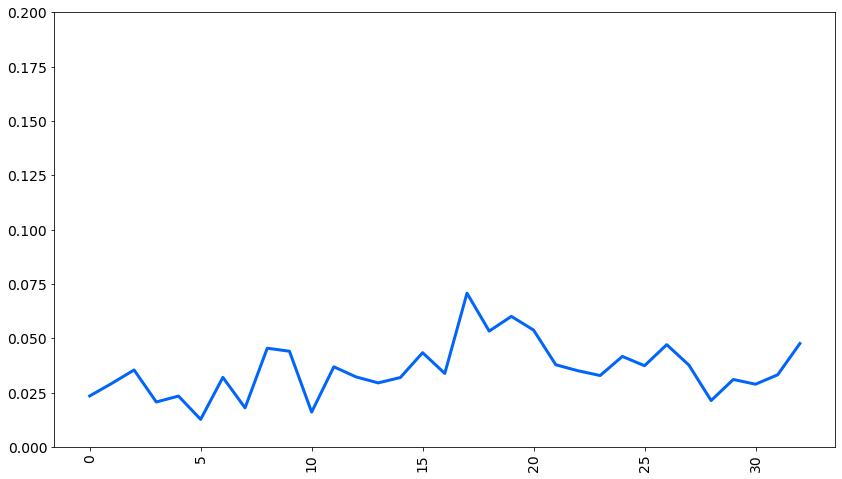

In [33]:
plt.figure(figsize=(14,8))
plt.plot(range(len(ret_ct)),ret_ct['ReturnNumber']/adopt_ct['AdoptNumber'],lw=3,color='xkcd:bright blue')
plt.plot(range(len(ret_ct)), poly1d_fn(range(len(ret_ct))), '--k') #'--k'=black dashed line, 'yo' = yellow circle marker
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0,0.2)

In [89]:
np.mean(ret_ct['ReturnNumber']/adopt_ct['AdoptNumber'])

0.03571492590330589

In [90]:
np.std(ret_ct['ReturnNumber']/adopt_ct['AdoptNumber'])

0.012510031349690264

0.03225806451612903

In [75]:
adopt[adopt['YearMonth']=='2021-12']

,ReturnType,ReturnReasonGroup,EventDate,YearMonth,AnimalID,AnimalName,AnimalBreed,BreedSize,IntakeAgeGroup,PartnerName,...,IsPreadoptionTraining,EverPreadoptionTraining,IsBiteHistory,IsResourceGuarder,IsOnLeashReactive,IsDefensiveAggression,IsHandlerGuarding,IsTerritorialAggression,IsOverArousal,IsFlightRisk
4,Dogs-TLAC,Other,2021-12-03 12:23:52,2021-12,9547,Ella Enchanted,"Retriever, Labrador/Mix",LargeMedium,7yr+,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,Dogs-TLAC,Other,2021-12-17 18:25:55,2021-12,17612,Noel Ryan,Boxer/Mix,LargeMedium,7yr+,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
38,Dogs-TLAC,Other,2021-12-04 19:07:07,2021-12,26550,Indigo,Bully Breed,LargeMedium,7yr+,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
49,Dogs-TLAC,Other,2021-12-08 17:05:53,2021-12,29251,Doreen,"Foxhound, English/Mix",LargeMedium,7yr+,None,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
78,Dogs-TLAC,Other,2021-12-08 17:10:57,2021-12,38908,Estella,Weimaraner/Mix,LargeMedium,1yr-7yr,None,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5225,Dogs-Tarrytown,Other,2021-12-03 12:51:04,2021-12,102786,Ozzy,Mixed Breed (Medium),LargeMedium,1yr-7yr,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5241,Dogs-Tarrytown,Other,2021-12-14 14:48:07,2021-12,102841,Jolly,"Chihuahua, Short Coat",Small,8mo-1yr,Austin Animal Center,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5375,Dogs-Tarrytown,Other,2021-12-20 17:46:16,2021-12,103187,Lupita,Chihuahua,Small,7yr+,Bastrop County Animal Services,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5406,Dogs-Tarrytown,Other,2021-12-23 16:52:02,2021-12,103252,Slippers,Maltese/Mix,Small,1yr-7yr,Austin Animal Center,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [64]:
ret[ret['YearMonth']=='2021-12']

,ReturnType,ReturnReasonGroup,EventDate,YearMonth,AnimalID,AnimalName,AnimalBreed,BreedSize,IntakeAgeGroup,PartnerName,...,IsPreadoptionTraining,EverPreadoptionTraining,IsBiteHistory,IsResourceGuarder,IsOnLeashReactive,IsDefensiveAggression,IsHandlerGuarding,IsTerritorialAggression,IsOverArousal,IsFlightRisk
10,Aggression towards animals,Behavior,2021-12-05 17:07:24,2021-12,93394,Eclipse,"Terrier, American Pit Bull/Mix",LargeMedium,1yr-7yr,Austin Animal Center,...,0,0,0,1,1,0,0,0,0,1
11,Aggression towards animals,Behavior,2021-12-10 17:36:26,2021-12,92717,Inez,Boxer/Mix,LargeMedium,1yr-7yr,RGVHS- old,...,0,0,0,1,1,0,0,0,0,1
12,Aggression towards animals,Behavior,2021-12-22 18:57:17,2021-12,100995,Hamilton,"Wolfhound, Irish/Mix",LargeMedium,7yr+,Nederland Animal Shelter,...,0,0,1,1,0,1,0,0,0,1
56,Aggression towards humans,Behavior,2021-12-03 12:55:30,2021-12,89489,Heloise,"Shepherd, German/Mix",LargeMedium,1yr-7yr,Austin Animal Center,...,0,1,0,0,0,0,0,0,0,0
57,Aggression towards humans,Behavior,2021-12-04 18:45:10,2021-12,100744,Prius,"Terrier, Cairn",Small,7yr+,Austin Animal Center,...,0,0,0,0,0,1,0,0,0,1
58,Aggression towards humans,Behavior,2021-12-28 16:14:49,2021-12,95214,Tahini,"Terrier, Jack Russell/Mix",Small,1yr-7yr,Austin Animal Center,...,0,0,1,1,1,1,0,0,0,0
130,Breed Restrictions,Other,2021-12-08 15:14:11,2021-12,101729,Paco,Shepherd/Mix,LargeMedium,8mo-1yr,Laredo Animal Care Services,...,0,0,0,0,0,0,0,0,0,0
177,Medical needs of animal,Medical,2021-12-19 18:09:12,2021-12,97711,Angelo,Mixed Breed (Large),LargeMedium,7yr+,None,...,0,0,0,0,0,0,0,0,0,0
277,Unrealistic Expectations,Other,2021-12-03 17:00:43,2021-12,101521,Brooks,"Corgi, Cardigan Welsh/Mix",LargeMedium,1yr-7yr,Bastrop County Animal Services,...,0,1,0,0,0,0,0,1,0,1
278,Unrealistic Expectations,Other,2021-12-28 15:56:37,2021-12,101521,Brooks,"Corgi, Cardigan Welsh/Mix",LargeMedium,1yr-7yr,Bastrop County Animal Services,...,0,1,0,0,0,0,0,1,0,1


(array([162.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  26.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

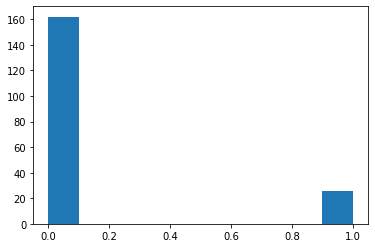

In [189]:
plt.hist(ue['IsMedicalConsult'])

(array([172.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  16.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

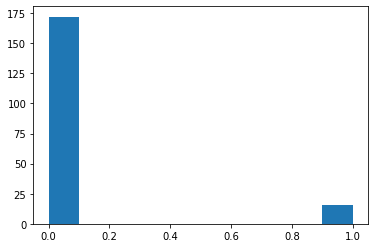

In [181]:
plt.hist(ue['IsPreadoptionTraining'])

In [186]:
collections.Counter(ue['IsPreadoptionTraining'])

Counter({1.0: 16, 0.0: 172})